<a href="https://colab.research.google.com/github/mmesbah/rc-anomaly-detector/blob/master/Rahnama_College_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HTTP Logs Anomaly Detection

Source: Sanjash server http logs.

Visit https://sanjagh.pro/

# Reference
1. [Time Series of Price Anomaly Detection](https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9)
2. [LSTM Auto Encoders](https://machinelearningmastery.com/lstm-autoencoders/)


## Prerequisite

### Update & Install packages

In [ ]:
!python3 -m pip install -U pip
!python3 -m pip install -U google-colab \
                           datascience \
                           albumentations \
                           tensorflow \
                           pandas-profiling \
                           user-agents

  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl (248 kB)
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached pandas_profiling-2.13.0-py2.py3-none-any.whl (245 kB)
  Using cached pandas_profiling-2.12.0-py2.py3-none-any.whl (244 kB)
  Using cached pandas_profiling-2.11.0-py2.py3-none-any.whl (243 kB)
  Using cached pandas_profiling-2.10.1-py2.py3-none-any.whl (240 kB)
  Using cached pandas_profiling-2.10.0-py2.py3-none-any.whl (239 kB)


### Import Libraries

In [ ]:
import re
import random
from pprint import pprint
import user_agents
from user_agents.parsers import UserAgent

import numpy as np
import pandas as pd
from scipy import sparse, stats
from scipy.sparse import csr_matrix
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint


### Mount Drive

Only run this part if you are running Colab Jupyter Notebook on a hosted runtime.

You will NOT need it on a local runtime.



In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Exploratory Data Analysis

### Preprocess

In [ ]:
def preprocess_dataset():
  colab_path = "drive/MyDrive/Colab\ Notebooks"
  ds_path = f"{colab_path}/rc-sanjagh.log"
  !head {ds_path}
  
  pp_ds_path = f"{colab_path}/rc-sanjagh.log.pp"
  !sed -e 's/\[\[/\"/g' -e 's/\]\]/\"/g' -e 's/\[//g' -e 's/\]//g' {ds_path} > {pp_ds_path}
  
  !echo "------------------------------"
  !head {pp_ds_path}  


preprocess_dataset()


207.213.193.143 [2021-5-12T5:6:0.0+0430] [Get /cdn/profiles/1026106239] 304 0 [[Googlebot-Image/1.0]] 32
207.213.193.143 [2021-5-12T5:6:0.0+0430] [Get images/badge.png] 304 0 [[Googlebot-Image/1.0]] 4
35.110.222.153 [2021-5-12T5:6:0.0+0430] [Get /pages/630180847] 200 52567 [[Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-J710GN Build/MMB29K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/4.0 Chrome/44.0.2403.133 Mobile Safari/537.36]] 32
35.108.208.99 [2021-5-12T5:6:0.0+0430] [Get images/fav_icon2.ico] 200 23531 [[Mozilla/5.0 (Linux; Android 6.0; CAM-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36]] 20
35.110.222.153 [2021-5-12T5:6:0.0+0430] [Get images/sanjagh_logo_purpule5.png] 200 4680 [[Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-J710GN Build/MMB29K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/4.0 Chrome/44.0.2403.133 Mobile Safari/537.36]] 8
35.110.222.153 [2021-5-12T5:6:0.0+0430] [Get css/font_awesome.min.css] 200 30891 [[Moz

### Read DataFrame

In [ ]:
def read_dataframe() -> pd.DataFrame:
  pp_ds_path = "drive/MyDrive/Colab Notebooks/rc-sanjagh.log.pp"
  df = pd.read_csv(pp_ds_path,
                   sep=" ",
                   names=[
                        "ip", "datetime", "method", "path",
                        "status_code", "response_length", "user_agent", "response_time"
                   ],
                   parse_dates=[
                        "datetime"
                   ],
                   infer_datetime_format=True,
                   dtype={
                        "status_code": str
                   })
  return df


df: pd.DataFrame = read_dataframe()
df


,ip,datetime,method,path,status_code,response_length,user_agent,response_time
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,images/badge.png,304,0,Googlebot-Image/1.0,4
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8
...,...,...,...,...,...,...,...,...
1260030,35.117.86.75,2021-05-12 15:08:59+04:30,Get,images/graystar_min.png,304,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4
1260031,35.117.86.75,2021-05-12 15:08:59+04:30,Get,fonts/sanjagh_icon_font_5.woff,304,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4
1260032,153.126.251.199,2021-05-12 15:08:59+04:30,Get,/api/v2/connect/215865643,101,0,okhttp/3.12.1,60003
1260033,207.213.207.102,2021-05-12 15:08:59+04:30,Get,/cdn/profiles/1289255230,304,0,Googlebot-Image/1.0,20


In [ ]:
def print_column_types(df: pd.DataFrame):
  for col in df.columns:
    print(col, df[col].dtype)


print_column_types(df)

ip object
datetime datetime64[ns, pytz.FixedOffset(270)]
method object
path object
status_code object
response_length int64
user_agent object
response_time object


### Data Cleansing

In [ ]:
def cleanse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
  # Dropping internal kubernetes requests (~19K rows)
  internal_requests: pd.DataFrame = df[df["ip"] == "-"]
  df.drop(internal_requests.index, inplace=True)

  # Dropping null response times (~1.7K)
  null_response_times: pd.DataFrame = df[df["response_time"] == "-"]
  df.drop(null_response_times.index, inplace=True)

  # Converting `response_time` column to numerical type
  df["response_time"] = df["response_time"].astype(np.int32)

  df.reset_index(drop=True, inplace=True)  
  return df


df = cleanse_dataframe(df)
df


,ip,datetime,method,path,status_code,response_length,user_agent,response_time
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,images/badge.png,304,0,Googlebot-Image/1.0,4
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8
...,...,...,...,...,...,...,...,...
1240222,35.117.86.75,2021-05-12 15:08:59+04:30,Get,images/graystar_min.png,304,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4
1240223,35.117.86.75,2021-05-12 15:08:59+04:30,Get,fonts/sanjagh_icon_font_5.woff,304,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4
1240224,153.126.251.199,2021-05-12 15:08:59+04:30,Get,/api/v2/connect/215865643,101,0,okhttp/3.12.1,60003
1240225,207.213.207.102,2021-05-12 15:08:59+04:30,Get,/cdn/profiles/1289255230,304,0,Googlebot-Image/1.0,20


### Remove Outliers

`response_length` and `response_time` columns are highly 
skewed.

Reduce skewness by removing outliers.


Further investigation:
* Plot the histogram after removing outliers to see if it is still skewed or not.
* Is it really needed? Or, their reconstruction error will be high in LSTM Auto encoders?

In [ ]:
def remove_outlier_response_lengths(df: pd.DataFrame) -> pd.DataFrame:
  # Dropping (1 rows)
  df = df[df["response_length"] < 5e7]
  
  # Dropping (1 rows)
  df = df[df["response_time"] < 1e7]

  df.reset_index(drop=True, inplace=True)
  return df

df = remove_outlier_response_lengths(df)


### Standard Scaling

Only for these features:
* `response_length`
* `response_time`


In [ ]:
def scale_features(df: pd.DataFrame):
  scaler = StandardScaler()

  print("Response time:\n----------------------")
  pprint(df["response_time"].describe())
  
  df["response_time"] = df["response_time"].apply(lambda t: np.log1p(t))
  print("After log(1+t):\n----------------------")
  pprint(df["response_time"].describe())
  
  df.loc[:, "response_time"] = scaler.fit_transform(df.loc[:, ["response_time"]])
  print("After standard scaling:\n----------------------")
  pprint(df["response_time"].describe())

  print("Response length:\n----------------------")
  pprint(df["response_length"].describe())
  
  df["response_length"] = df["response_length"].apply(lambda l: np.log1p(l))
  print("After log(1+t):\n----------------------")
  pprint(df["response_length"].describe())
  
  df.loc[:, "response_length"] = scaler.fit_transform(df.loc[:, ["response_length"]])
  print("After standard scaling:\n----------------------")
  pprint(df["response_length"].describe())

  return df


df = scale_features(df)


Response time:
----------------------
count    1.240216e+06
mean     6.534881e+03
std      6.085229e+04
min      0.000000e+00
25%      4.000000e+00
50%      1.200000e+01
75%      2.400000e+01
max      9.970583e+06
Name: response_time, dtype: float64
After log(1+t):
----------------------
count    1.240216e+06
mean     2.893604e+00
std      2.193349e+00
min      0.000000e+00
25%      1.609438e+00
50%      2.564949e+00
75%      3.218876e+00
max      1.611515e+01
Name: response_time, dtype: float64
After standard scaling:
----------------------
count    1.240216e+06
mean     1.934373e-13
std      1.000000e+00
min     -1.319264e+00
25%     -5.854822e-01
50%     -1.498417e-01
75%      1.482991e-01
max      6.028019e+00
Name: response_time, dtype: float64
Response length:
----------------------
count    1.240216e+06
mean     4.640436e+04
std      3.249569e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.201000e+03
75%      2.741100e+04
max      3.104202e+07
Name: response_length, d

### Profile Report

It's recommented to run this cell on a local runtime.

If you run it on a hosted runtime instead, Colab will probably crash due to excessive RAM usage.

The cell will take ~10 min on a local runtime.

In [ ]:
profile = ProfileReport(df,
                        title="Sanjagh HTTP Logs",
                        correlations={
                          "pearson": {
                            "calculate": True,
                            "warn_high_correlations": True,
                            "threshold": 0.9
                          },
                          "spearman": {
                            "calculate": False,
                            "warn_high_correlations": False,
                            "threshold": 0.9
                          },
                          "kendall": {
                            "calculate": False,
                            "warn_high_correlations": False,
                            "threshold": 0.9
                          },
                          "phi_k": {
                            "calculate": False, 
                            "warn_high_correlations": False,
                            "threshold": 0.9
                          },
                          "cramers": {
                            "calculate": False,
                            "warn_high_correlations": True,
                            "threshold": 0.9
                          }
                        },
                        plot={
                            "histogram": {
                                "bins": 20
                            }
                        },
                        interactions={
                            "continuous": True
                        },
                        duplicates={
                            "head": 10
                        })
profile.to_file("sanjagh_report.html")


Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Selection

### Path

We simply replace decimal numbers in path with `<NUM>`.

In [ ]:
def update_path(path: pd.Series) -> pd.Series:
  print("Unique paths count:", len(path.unique()))
  
  updated_path = path.apply(lambda p: re.sub("\\d+", "<NUM>", p))
  print("Unique updated paths count:", len(updated_path.unique()))
  
  return updated_path


df["updated_path"] = update_path(df["path"])


Unique paths count: 138803
Unique updated paths count: 276


In [ ]:
def show_values(updated_path: pd.Series):
  vc = updated_path.value_counts()
  for up in vc.index:
    print(up, vc[up])


show_values(df["updated_path"])


/cdn/pro_photo_gallery/<NUM> 115094
/cdn/profiles/<NUM> 82802
/api/v<NUM>/token 64915
/api/v<NUM>/connect/<NUM> 62033
/cdn/articles/<NUM> 52708
/cdn/servicePic/<NUM> 47835
js/sentry.<NUM>b<NUM>bac<NUM>b<NUM>ac<NUM>b<NUM>c.js 35992
fonts/IRANSansWeb_Light.woff<NUM> 34065
/<NUM> 33425
js/lazyload.<NUM>f<NUM>.js 33328
fonts/fontawesome_webfont.woff<NUM>?v=<NUM>.<NUM>.<NUM> 32118
fonts/sanjagh_icon_font_<NUM>.woff 29037
images/sanjagh_logo_purpule<NUM>.png 27555
images/aparat_logo.png 25957
/api/v<NUM>/apps 23699
css/font_awesome.min.css 21516
js/index.<NUM>e<NUM>a<NUM>b<NUM>f<NUM>ad<NUM>d.js 20262
images/sanjaghmaglogo<NUM>.png 19394
images/fav_icon<NUM>.ico 18733
images/gadgets/join_pros<NUM>.jpg 18324
/pages/<NUM> 18190
css/page.<NUM>f<NUM>fc<NUM>da<NUM>cdff<NUM>.css 18181
js/page.<NUM>cb<NUM>dc<NUM>eef<NUM>.js 17941
templates/service.html 17825
images/default_images/default_<NUM>x<NUM>.jpg 16200
images/default.jpg 14553
/api/cs<NUM>/uxEvents 14247
images/graystar_min.png 13266
images/s

### User Agent

Try to parse user agents string with `user_agents` python library.

Raw user agents unique value counts: ~11K.
* Not suitable for one-hot encoding.

If we just get `str(user_agents.parse(raw_ua))`, the unique values reduces to ~8K.
* Not yet suitable for one-hot encoding.

We will take the following features for one-hot encoding:
* Browser family
* OS family
* Device brand

Based on the unique value counts, we will have 
`78 + 13 + 29 = 120` one-hot features.

`version` values are not advantageous, because they are repetitively updating.

In [ ]:
def show_random_user_agent(df: pd.DataFrame):
  idx: int = random.choice(df.index)
  raw_ua: str = df.at[idx, "user_agent"]

  ua: UserAgent = user_agents.parse(raw_ua)
  print("Raw user agent:", raw_ua)
  
  #print("Browser:", ua.browser)
  print("Browser family:", ua.browser.family)
  print("Browser version:", ua.browser.version_string)
  
  #print("OS:", ua.os)
  print("OS family:", ua.os.family)
  print("OS version:", ua.os.version_string)

  #print("Device:", ua.device)
  print("Device family:", ua.device.family)
  print("Device brand:", ua.device.brand)
  print("Device model:", ua.device.model)

  print("--------------------")
  print("toString:", str(ua))



show_random_user_agent(df)


Raw user agent: Mozilla/5.0 (Linux; Android 10; Redmi Note 9S) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36
Browser family: Chrome Mobile
Browser version: 91.0.4472
OS family: Android
OS version: 10
Device family: XiaoMi Redmi Note 9S
Device brand: XiaoMi
Device model: Redmi Note 9S
--------------------
toString: XiaoMi Redmi Note 9S / Android 10 / Chrome Mobile 91.0.4472


In [ ]:
def extract_ua_features(ua: pd.Series) -> pd.DataFrame:
  """
  Running time: ~5 mins.
  """
  parsed_ua: pd.Series = ua.apply(lambda a: user_agents.parse(a))
  parsed_ua.rename("parsed_ua", inplace=True)
  ua_features = pd.DataFrame(parsed_ua)
  
  ua_features["ua_browser_family"] = parsed_ua.apply(lambda a: a.browser.family)
  ua_features["ua_browser_version"] = parsed_ua.apply(lambda a: a.browser.version_string)

  ua_features["ua_os_family"] = parsed_ua.apply(lambda a: a.os.family)
  ua_features["ua_os_version"] = parsed_ua.apply(lambda a: a.os.version_string)

  ua_features["ua_device_brand"] = parsed_ua.apply(lambda a: a.device.brand)
  ua_features["ua_device_model"] = parsed_ua.apply(lambda a: a.device.model)

  return ua_features


ua_features: pd.DataFrame = extract_ua_features(df["user_agent"])
ua_features


,parsed_ua,ua_browser_family,ua_browser_version,ua_os_family,ua_os_version,ua_device_brand,ua_device_model
0,Spider / Other / Googlebot-Image 1.0,Googlebot-Image,1.0,Other,,Spider,Desktop
1,Spider / Other / Googlebot-Image 1.0,Googlebot-Image,1.0,Other,,Spider,Desktop
2,Samsung SM-J710GN / Android 6.0.1 / Samsung In...,Samsung Internet,4.0,Android,6.0.1,Samsung,SM-J710GN
3,Huawei CAM-L21 / Android 6.0 / Chrome Mobile 9...,Chrome Mobile,91.0.4472,Android,6.0,Huawei,CAM-L21
4,Samsung SM-J710GN / Android 6.0.1 / Samsung In...,Samsung Internet,4.0,Android,6.0.1,Samsung,SM-J710GN
...,...,...,...,...,...,...,...
1240211,XiaoMi Redmi 7A / Android 9 / Chrome Mobile 80...,Chrome Mobile,80.0.3987,Android,9,XiaoMi,Redmi 7A
1240212,XiaoMi Redmi 7A / Android 9 / Chrome Mobile 80...,Chrome Mobile,80.0.3987,Android,9,XiaoMi,Redmi 7A
1240213,Other / Other / okhttp 3.12.1,okhttp,3.12.1,Other,,None,None
1240214,Spider / Other / Googlebot-Image 1.0,Googlebot-Image,1.0,Other,,Spider,Desktop


In [ ]:
def ua_features_value_count(ua_features: pd.DataFrame):
  print("Unique values:\n-------------------------")
  print("Browser family:", len(ua_features["ua_browser_family"].unique()))
  print("Browser version:", len(ua_features["ua_browser_version"].unique()))

  print("OS family", len(ua_features["ua_os_family"].unique()))
  print("OS version", len(ua_features["ua_os_version"].unique()))

  print("Device brand", len(ua_features["ua_device_brand"].unique()))
  print("Device model", len(ua_features["ua_device_model"].unique()))


ua_features_value_count(ua_features)


Unique values:
-------------------------
Browser family: 78
Browser version: 590
OS family 13
OS version 157
Device brand 29
Device model 1118


In [ ]:
def ua_features_na_values_count(ua_features: pd.DataFrame):
  print("NA values:\n-------------------------")
  print("Browser family:", sum(ua_features["ua_browser_family"].isna()))
  print("Browser version:", sum(ua_features["ua_browser_version"].isna()))

  print("OS family:", sum(ua_features["ua_os_family"].isna()))
  print("OS version:", sum(ua_features["ua_os_version"].isna()))

  print("Device brand:", sum(ua_features["ua_device_brand"].isna()))
  print("Device model:", sum(ua_features["ua_device_model"].isna()))


def ua_features_fill_na(ua_features: pd.DataFrame):
  ua_features["ua_device_brand"].fillna("UNKNOWN", inplace=True)
  ua_features["ua_device_model"].fillna("UNKNOWN", inplace=True)


ua_features_na_values_count(ua_features)
ua_features_fill_na(ua_features)

print("\nCheck if filled correctly:\n-------------------------")
ua_features_na_values_count(ua_features)


NA values:
-------------------------
Browser family: 0
Browser version: 0
OS family: 0
OS version: 0
Device brand: 369661
Device model: 369676

Check if filled correctly:
-------------------------
NA values:
-------------------------
Browser family: 0
Browser version: 0
OS family: 0
OS version: 0
Device brand: 0
Device model: 0


### One Hot Encoding

In [ ]:
def encode_categorical_features(df: pd.DataFrame, ua_features: pd.DataFrame) -> csr_matrix:
  df = pd.concat([df, ua_features], axis=1)
  categorical_df: pd.DataFrame = df.loc[:,
                                        ["method", "updated_path", "status_code",
                                         "ua_browser_family", "ua_os_family", "ua_device_brand"]
                                        ]
  encoder = OneHotEncoder()
  one_hot_feats: csr_matrix = encoder.fit_transform(categorical_df)
  return one_hot_feats

one_hot_feats: csr_matrix = encode_categorical_features(df, ua_features)
print("Encoded One Hot Features:")
pprint(one_hot_feats)

print("Sample (Row 0):")
print(one_hot_feats[0].toarray())


Encoded One Hot Features:
<1240216x417 sparse matrix of type '<class 'numpy.float64'>'
	with 7441296 stored elements in Compressed Sparse Row format>
Sample (Row 0):
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 

## Train Data Formation

### Reduce Datafame Size

For simplicity and time shortage, we just make `df` smaller.

**Attention:** If you have enough time, DONT reduce `df` size.



In [ ]:
df = df.loc[0:100_000, :]
df

,ip,datetime,method,path,status_code,response_length,user_agent,response_time,updated_path
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,/cdn/profiles/1026106239,304,-1.210556,Googlebot-Image/1.0,0.274878,/cdn/profiles/<NUM>
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,images/badge.png,304,-1.210556,Googlebot-Image/1.0,-0.585482,images/badge.png
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,/pages/630180847,200,1.054402,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,0.274878,/pages/<NUM>
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,images/fav_icon2.ico,200,0.886925,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,0.068807,images/fav_icon<NUM>.ico
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,images/sanjagh_logo_purpule5.png,200,0.550438,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,-0.317496,images/sanjagh_logo_purpule<NUM>.png
...,...,...,...,...,...,...,...,...,...
99996,35.220.57.142,2021-05-12 06:35:15+04:30,Get,/cdn/profiles/1040409560,200,0.709687,Mozilla/5.0 (Linux; Android 10; Redmi Note 8) ...,0.327040,/cdn/profiles/<NUM>
99997,36.67.23.210,2021-05-12 06:35:15+04:30,Head,/877499224,200,-1.210556,Go-http-client/2.0,0.068807,/<NUM>
99998,35.220.57.142,2021-05-12 06:35:15+04:30,Get,/cdn/profiles/1174703202,200,0.523027,Mozilla/5.0 (Linux; Android 10; Redmi Note 8) ...,0.215967,/cdn/profiles/<NUM>
99999,92.130.130.223,2021-05-12 06:35:15+04:30,Get,/pages/2098538394,200,1.054909,Mozilla/5.0 (iPhone; CPU iPhone OS 12_5 like M...,-0.149842,/pages/<NUM>


### Find Sequence of Requests

Group `df` rows by `ip` column, and you find list of requests per IP.

*Improvement:* What about using df.groupby("ip") rather than using `dict`?


In [ ]:
def group_requests_by_ip(df: pd.DataFrame) -> dict:
  reqs = {
      # ip -> list of requests
  }
  for i, row in df.iterrows():
    ip: str = row["ip"]
    if ip not in reqs:
      reqs[ip] = []

    new_req = sparse.hstack([
                            i,
                            row["datetime"].timestamp(),
                            row["response_length"],
                            row["response_time"],
                            one_hot_feats[i]
    ])
    reqs[ip].append(new_req)

  return reqs


def print_requests_summary(reqs: dict):
  print("Requests count:", len(reqs))
  for ip, seq in reqs.items():
    print("Sample ip:", ip)
    print("Seq length:", len(seq))
    print("Sample seq:", seq[0:10])
    break


reqs: dict = group_requests_by_ip(df)
print_requests_summary(reqs)


Requests count: 5221
Sample ip: 207.213.193.143
Seq length: 4973
Sample seq: [<1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>, <1x421 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate forma

### Build X

X.shape is `(None, time_steps, request_features_count)`.
* `None` means equal to the batch size, whatever it is.
* `time_steps` means the length of time series. here it is 10.
* `request_features_count` means the number of features for each single request. After one hot encoding, we have[link text](https://) 420 featuers.

So, X.shape is `(None, 10, 420)`.

In [ ]:
time_steps = 10

def generate_X(reqs: dict):
  for ip, seq in reqs.items():
    length = len(seq)
    for i in range(length - time_steps):
      x = seq[i:(i+time_steps)]
      x = np.vstack([req.toarray() for req in x])

      # Modifying first feature of x:
      #     timestamp -> timestamp diff from the firt req
      tstamp_col_idx = 1
      x[:, tstamp_col_idx] = x[:, tstamp_col_idx] - x[0, tstamp_col_idx]
      yield x


X = np.array(list(generate_X(reqs)))
print("X:", X.shape)
X_train, X_test = train_test_split(X, train_size=0.8)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# Remove df indices from X
X_train_1 = X_train[:, :, 1:]
X_test_1 = X_test[:, :, 1:]
print("X_train_1:", X_train_1.shape)
print("X_test_1:", X_test_1.shape)


X: (55704, 10, 421)
X_train: (44563, 10, 421)
X_test: (11141, 10, 421)
X_train_1: (44563, 10, 420)
X_test_1: (11141, 10, 420)


## Model Training

If your training takes several hours, just copy the following js script in your browser console to force Colab to stay awake:

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 60000);
```

Source: [Stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting).



In [ ]:
def create_model():
  model = Sequential()
  model.add(LSTM(32, input_shape=(X_train_1.shape[1], X_train_1.shape[2])))
  model.add(Dropout(rate=0.2))
  model.add(RepeatVector(X_train_1.shape[1]))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(X_train_1.shape[2])))
  return model

 
model = create_model()
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                57984     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 420)           13860     
Total params: 80,164
Trainable params: 80,164
Non-trainable params: 0
__________________________________________________

In [ ]:
checkpoint_dir = "drive/MyDrive/Colab Notebooks/rc-sanjagh-model"
checkpoint_path = f"{checkpoint_dir}/rc-sanjagh-model.ckpt"
EPOCHS = 60


In [ ]:
def train_model():
  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                verbose=1)
  
  history = model.fit(X_train_1,
                      X_train_1,
                      epochs=EPOCHS,
                      callbacks=[cp_callback])
  return history


train_history = train_model()


Epoch 1/60
1393/1393 [==============================] - 32s 20ms/step - loss: 0.1006

Epoch 00001: saving model to drive/MyDrive/Colab Notebooks/rc-sanjagh-model/rc-sanjagh-model.ckpt
Epoch 2/60
1393/1393 [==============================] - 29s 21ms/step - loss: 0.0887

Epoch 00002: saving model to drive/MyDrive/Colab Notebooks/rc-sanjagh-model/rc-sanjagh-model.ckpt
Epoch 3/60
1393/1393 [==============================] - 30s 21ms/step - loss: 0.0754

Epoch 00003: saving model to drive/MyDrive/Colab Notebooks/rc-sanjagh-model/rc-sanjagh-model.ckpt
Epoch 4/60
1393/1393 [==============================] - 27s 20ms/step - loss: 0.0714

Epoch 00004: saving model to drive/MyDrive/Colab Notebooks/rc-sanjagh-model/rc-sanjagh-model.ckpt
Epoch 5/60
1393/1393 [==============================] - 27s 19ms/step - loss: 0.0683

Epoch 00005: saving model to drive/MyDrive/Colab Notebooks/rc-sanjagh-model/rc-sanjagh-model.ckpt
Epoch 6/60
1393/1393 [==============================] - 27s 19ms/step - loss: 0.

In [ ]:
plt.plot(train_history.history['loss'], label='Training loss')
plt.plot(train_history.history['val_loss'], label='Validation loss')
plt.legend();


## Model Test

### Load Model

Load trained model from the checkpoints if needed.

In [ ]:
model.load_weights(checkpoint_path)

### Evaluate

In [ ]:
model.evaluate(X_test_1, X_test_1)

349/349 [==============================] - 3s 6ms/step - loss: 0.0350


0.03498247265815735

## Anomaly Detection

A sequence of requests is designated as "anomaly", if and only if its reconstruction error throught LSTM Autoencoder is higher than a specified threshold.

### Compute MAE Loss

Compute and plot mean absolute error loss.


In [ ]:
def compute_mae_loss(X_custom: np.array) -> np.array:
  X_custom_pred: np.array = model.predict(X_custom, verbose=1)
  mae_loss: np.array = np.mean(np.abs(X_custom_pred - X_custom), axis=(1, 2))
  return mae_loss


def plot_mae_loss(mae_loss: np.array, bins=50):  
  plt.hist(mae_loss, bins=bins)
  plt.xlabel('MAE loss')
  plt.ylabel('Number of Samples')

  threshold = np.max(mae_loss)
  print(f"Reconstruction error threshold: {threshold}")


1393/1393 [==============================] - 8s 5ms/step
Reconstruction error threshold: 8.179268711922326
Train MAE loss shape: (44563,)


DescribeResult(nobs=44563, minmax=(0.006326969957133654, 8.179268711922326), mean=0.03580086423111704, variance=0.047766494244463775, skewness=19.98021043971946, kurtosis=503.64015567846326)

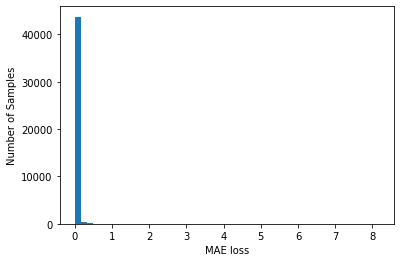

In [ ]:
train_mae_loss: np.array = compute_mae_loss(X_train_1)
plot_mae_loss(train_mae_loss)
print("Train MAE loss shape:", train_mae_loss.shape)
stats.describe(train_mae_loss)


349/349 [==============================] - 2s 6ms/step
Reconstruction error threshold: 7.205968423099832
Test MAE loss shape: (11141,)


DescribeResult(nobs=11141, minmax=(0.006489526810272103, 7.205968423099832), mean=0.03498247044547442, variance=0.04025319601351748, skewness=19.634231626048177, kurtosis=506.0696283987188)

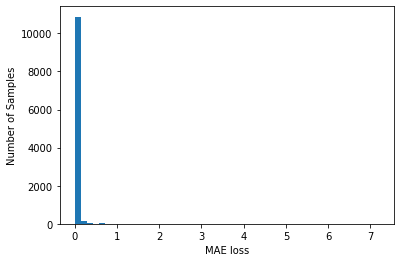

In [ ]:
test_mae_loss: np.array = compute_mae_loss(X_test_1)
plot_mae_loss(test_mae_loss)
print("Test MAE loss shape:", test_mae_loss.shape)
stats.describe(test_mae_loss)


### Determine Anomalies

In [ ]:
ANOMALY_THRESHOLD = 1

def determine_anomalies(X_custom: np.array, mae_loss: np.array) -> pd.DataFrame:
  anomalies: np.array = (mae_loss > ANOMALY_THRESHOLD)
  df_indices: np.array = X_custom[anomalies.nonzero(), :, 0]
  df_indices: np.array = df_indices.flatten()
  
  print("Count:", len(df_indices))
  df_indices = set(df_indices)
  print("Unique count:", len(df_indices))
  df_indices: list = sorted(df_indices)

  anomaly_df: pd.DataFrame = df.loc[df_indices, :]
  return anomaly_df



In [ ]:
train_anomaly_df: pd.DataFrame = determine_anomalies(X_train, train_mae_loss)
train_anomaly_df

Count: 2360
Unique count: 817


,ip,datetime,method,path,status_code,response_length,user_agent,response_time,updated_path
86.0,114.130.184.163,2021-05-12 05:06:03+04:30,Put,/api/v2/token,200,-0.029121,Mozilla/5.0 (Linux; Android 10; SM-A105F) Appl...,-0.149842,/api/v<NUM>/token
124.0,114.130.184.163,2021-05-12 05:06:03+04:30,Get,/manifest.json,304,-1.210556,Mozilla/5.0 (Linux; Android 10; SM-A105F) Appl...,-0.585482,/manifest.json
138.0,114.130.184.163,2021-05-12 05:06:04+04:30,Get,images/icons/xhdpi.png,304,-1.210556,Mozilla/5.0 (Linux; Android 10; SM-A105F) Appl...,-1.319264,images/icons/xhdpi.png
757.0,20.62.177.11,2021-05-12 05:06:30+04:30,Get,/pros/1993352776,200,1.057986,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,1.203541,/pros/<NUM>
983.0,35.117.34.214,2021-05-12 05:06:46+04:30,Get,images/sanjaghmaglogo1.png,200,0.906823,Mozilla/5.0 (Linux; Android 8.0.0; PRA-LA1) Ap...,-1.319264,images/sanjaghmaglogo<NUM>.png
...,...,...,...,...,...,...,...,...,...
99977.0,35.103.12.125,2021-05-12 06:35:14+04:30,Get,js/sentry.47b4061bac0b8ac89b9c.js,304,-1.210556,Mozilla/5.0 (Linux; Android 10; MAR-LX1M) Appl...,-1.319264,js/sentry.<NUM>b<NUM>bac<NUM>b<NUM>ac<NUM>b<NU...
99978.0,35.103.12.125,2021-05-12 06:35:14+04:30,Get,fonts/IRANSansWeb_Light.woff2,304,-1.210556,Mozilla/5.0 (Linux; Android 10; MAR-LX1M) Appl...,-0.149842,fonts/IRANSansWeb_Light.woff<NUM>
99979.0,35.103.12.125,2021-05-12 06:35:14+04:30,Get,fonts/sanjagh_icon_font_5.woff,304,-1.210556,Mozilla/5.0 (Linux; Android 10; MAR-LX1M) Appl...,0.068807,fonts/sanjagh_icon_font_<NUM>.woff
99980.0,35.103.12.125,2021-05-12 06:35:14+04:30,Get,fonts/fontawesome_webfont.woff2?v=4.7.0,304,-1.210556,Mozilla/5.0 (Linux; Android 10; MAR-LX1M) Appl...,0.068807,fonts/fontawesome_webfont.woff<NUM>?v=<NUM>.<N...


In [ ]:
train_anomaly_df.loc[:, "user_agent"].unique()

array(['Mozilla/5.0 (Linux; Android 10; SM-A105F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Mobile Safari/537.36',
       'Mozilla/5.0 (compatible; SemrushBot/7~bl; +http://www.semrush.com/bot.html)',
       'Mozilla/5.0 (Linux; Android 8.0.0; PRA-LA1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36',
       'Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL00) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.105 Mobile Safari/537.36',
       'FreshpingBot/1.0 (+https://freshping.io/)',
       'Mozilla/5.0 (Linux; Android 10; M2010J19CG) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36',
       'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.90 Mobile Safari/537.36 (compatible; Google-AMPHTML)',
       'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.90 Mobile Safari/537.3

In [ ]:
test_anomaly_df: pd.DataFrame = determine_anomalies(X_test, test_mae_loss)
test_anomaly_df

Count: 590
Unique count: 419


,ip,datetime,method,path,status_code,response_length,user_agent,response_time,updated_path
138.0,114.130.184.163,2021-05-12 05:06:04+04:30,Get,images/icons/xhdpi.png,304,-1.210556,Mozilla/5.0 (Linux; Android 10; SM-A105F) Appl...,-1.319264,images/icons/xhdpi.png
1154.0,35.244.109.44,2021-05-12 05:06:52+04:30,Get,js/sentry.47b4061bac0b8ac89b9c.js,304,-1.210556,Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL...,-0.149842,js/sentry.<NUM>b<NUM>bac<NUM>b<NUM>ac<NUM>b<NU...
1155.0,35.244.109.44,2021-05-12 05:06:52+04:30,Get,js/lazyload.797291581158393f5011.js,304,-1.210556,Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL...,-0.149842,js/lazyload.<NUM>f<NUM>.js
1165.0,35.244.109.44,2021-05-12 05:06:52+04:30,Get,fonts/IRANSansWeb_Light.woff2,304,-1.210556,Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL...,-0.149842,fonts/IRANSansWeb_Light.woff<NUM>
1167.0,35.244.109.44,2021-05-12 05:06:52+04:30,Get,images/aparat_logo.png,304,-1.210556,Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL...,-0.585482,images/aparat_logo.png
...,...,...,...,...,...,...,...,...,...
99361.0,92.239.223.10,2021-05-12 06:34:04+04:30,Get,js/page.07cb314dc14eef820638.js,304,-1.210556,Mozilla/5.0 (Linux; Android 10; M2004J19C) App...,-0.585482,js/page.<NUM>cb<NUM>dc<NUM>eef<NUM>.js
99362.0,92.239.223.10,2021-05-12 06:34:04+04:30,Get,images/sanjaghmaglogo1.png,304,-1.210556,Mozilla/5.0 (Linux; Android 10; M2004J19C) App...,-0.149842,images/sanjaghmaglogo<NUM>.png
99363.0,92.239.223.10,2021-05-12 06:34:04+04:30,Get,js/sentry.47b4061bac0b8ac89b9c.js,304,-1.210556,Mozilla/5.0 (Linux; Android 10; M2004J19C) App...,-0.149842,js/sentry.<NUM>b<NUM>bac<NUM>b<NUM>ac<NUM>b<NU...
99364.0,92.239.223.10,2021-05-12 06:34:04+04:30,Get,images/gadgets/join_pros3.jpg,304,-1.210556,Mozilla/5.0 (Linux; Android 10; M2004J19C) App...,-0.149842,images/gadgets/join_pros<NUM>.jpg


In [ ]:
test_anomaly_df.loc[:, "user_agent"].unique()

array(['Mozilla/5.0 (Linux; Android 10; SM-A105F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Mobile Safari/537.36',
       'Mozilla/5.0 (Linux; Android 5.1; HUAWEI TIT-AL00) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.105 Mobile Safari/537.36',
       'Mozilla/5.0 (compatible; SemrushBot/7~bl; +http://www.semrush.com/bot.html)',
       'Mozilla/5.0 (Linux; Android 10; M2010J19CG) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36',
       'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.90 Mobile Safari/537.36 (compatible; Google-AMPHTML)',
       'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.90 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
       'Googlebot-Image/1.0',
       'Mozilla/5.0 (Linux; Android 10; Redmi Note 9 Pro) AppleWebKit/537.36 (KHTML, like G

### Evaluation

Are the anomalies truely detected?

Here comes the list of anomalies, according to the Rahnama College mentors:
* Reuqests from Google!
  * `user_agent = %Google%`
* Crawlers:
  * `user_agent = python-requests/2.18.1`
  * `user_agent = Python-urllib/3.7`
  * There are only 6 requests with these crawlers!
* A non-distructive robot:
  * `user_agent = Go-http-client`
* An attacker:
  * `user_agent = blackBerry`
